In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.deterministic import Fourier
from statsmodels.tsa.tsatools import add_trend
import statsmodels.api as sm
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-05-30T22:33:07.514114+03:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.21.0

Compiler    : GCC 13.2.1 20240503
OS          : Linux
Release     : 6.9.2-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [2]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [4]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)

        area = requests.get(
            f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-05-30: 100%|██████████| 929/929 [03:56<00:00,  3.92it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
4712,#bcaaa4,640.049498,0.106,unspecified,2024-05-30 01:01:39
4713,#0f9d58,42968.372688,7.118,liberated,2024-05-30 01:01:39
4714,#ff5252,139991.513798,23.189,other_territories,2024-05-30 01:01:39
4715,#880e4f,43974.034421,7.284,occupied_to_24_02_2022,2024-05-30 01:01:39


In [7]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [8]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [9]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [10]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_20472/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [ ]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-05-26                    liberated
2024-05-26    occupied_after_24_02_2022
2024-05-26       occupied_to_24_02_2022
2024-05-26            other_territories
2024-05-26                  unspecified
Name: type, Length: 3499, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [ ]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [ ]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [12]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa["prefix"] = 0
aa.loc[:"2022-11-11", "prefix"] = 1
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-05-26,65156.751229,0
2024-05-27,65166.920002,0
2024-05-28,65172.131364,0
2024-05-29,65173.689731,0


In [ ]:
best_ff = None
best_aic = 99e99
for order in range(1, 3):
    for period in np.linspace(order * 2, 2 * 365.25, 100):
        fourier_gen = Fourier(period, order)
        ff = fourier_gen.in_sample(aa.index)
        ff["prefix"] = aa["prefix"]
        ff = add_trend(ff, "ct")
        model = sm.OLS(aa["area"], ff).fit()
        if best_ff is None or best_aic > model.aic:
            best_ff = model
best_ff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     683.8
Date:                Sun, 26 May 2024   Prob (F-statistic):          3.22e-306
Time:                        20:00:16   Log-Likelihood:                -7232.1
No. Observations:                 785   AIC:                         1.448e+04
Df Residuals:                     778   BIC:                         1.451e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
sin(1,730.50)  1479.6074    194.473      7.608      0.000    1097.853    1861.361
cos(1,730.50)  2921.1078    223.295     13.082      0.000    2482.775    3359.440
sin(2,730.50)  2752.2614    157.983     17.421      0.000    2442.138    3062.385
cos(2,730.50)  -737.7507    142.388     -5.181      0.000   -1017.261    -458.240
prefix         2358.8144    636.599      3.705      0.000    1109.160    3608.469
const          7.159e+04    550.307    130.091      0.000    7.05e+04    7.27e+04
trend           -11.1379      1.007    -11.056      0.000     -13.115      -9.160
==============================================================================
Omnibus:                      239.011   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1099.896
Skew:                          -1.327   Prob(JB):                    1.45e-239
Kurtosis:                       8.156   Cond. No.                     4.43e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Axes: >

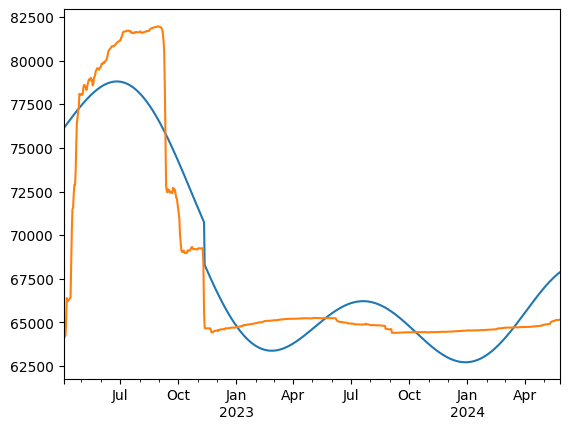

In [ ]:
best_ff.predict(ff).plot()
aa["area"].plot()

,area
2022-11-11,65643.549000
2022-11-12,64686.480172
2022-11-13,64681.326164
2022-11-14,64656.858826
2022-11-15,64656.858826
...,...
2024-05-22,65141.514897
2024-05-23,65143.511630
2024-05-24,65144.012024
2024-05-25,65147.304416


In [ ]:
aa.loc["2022-02-03":]

,area
2022-04-03,63714.938326
2022-04-04,64256.540524
2022-04-05,64193.626525
2022-04-06,64261.353774
2022-04-07,65046.306239
...,...
2024-05-22,65141.514897
2024-05-23,65143.511630
2024-05-24,65144.012024
2024-05-25,65147.304416


In [ ]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")

xx = add_trend(xx, "ct")
xx

NameError: name 'add_trend' is not defined

In [14]:
best_model = None
for p in range(6):
    for q in range(6):
        mod = ARIMA(aa["area"], order=(p, 1, q)).fit()
        if best_model is None or best_model.aic > mod.aic:
            best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/v_0ver/venv/myds312/lib/python3.12/site-packag

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  789
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -5203.273
Date:                Thu, 30 May 2024   AIC                          10426.547
Time:                        22:39:04   BIC                          10473.242
Sample:                    04-03-2022   HQIC                         10444.497
                         - 05-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0392      0.083     12.486      0.000       0.876       1.202
ar.L2         -1.0068      0.067    -15.125      0.000      -1.137      -0.876
ar.L3          0.9980      0.065     15.262      0.000       0.870       1.126
ar.L4         -0.0751      0.069     -1.091      0.275      -0.210       0.060
ma.L1         -0.3031      0.083     -3.662      0.000      -0.465      -0.141
ma.L2          0.5670      0.025     23.097      0.000       0.519       0.615
ma.L3         -0.5624      0.045    -12.591      0.000      -0.650      -0.475
ma.L4         -0.2633      0.038     -6.882      0.000      -0.338      -0.188
ma.L5         -0.2221      0.038     -5.910      0.000      -0.296      -0.148
sigma2      2.758e+04    306.484     89.990      0.000     2.7e+04    2.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   7.67   Jarque-Bera (JB):            108037.01
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -3.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        60.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-05-31,65183.817873,166.073344,64858.320101,65509.315645
2024-06-01,65191.956256,332.729970,64539.817498,65844.095014
2024-06-02,65195.298989,477.379692,64259.651986,66130.945993
2024-06-03,65197.418477,590.572204,64039.918228,66354.918726
2024-06-04,65203.590142,694.103185,63843.172899,66564.007385
...,...,...,...,...
2024-09-23,65375.191313,7054.640451,51548.350106,79202.032521
2024-09-24,65375.600544,7097.171593,51465.399830,79285.801258
2024-09-25,65375.874087,7139.521135,51382.669794,79369.078379
2024-09-26,65376.013478,7181.638802,51300.260076,79451.766881


In [16]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha / 100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

In [19]:
aa

,area,prefix
2022-04-03,63714.938326,1
2022-04-04,64256.540524,1
2022-04-05,64193.626525,1
2022-04-06,64261.353774,1
2022-04-07,65046.306239,1
...,...,...
2024-05-26,65156.751229,0
2024-05-27,65166.920002,0
2024-05-28,65172.131364,0
2024-05-29,65173.689731,0


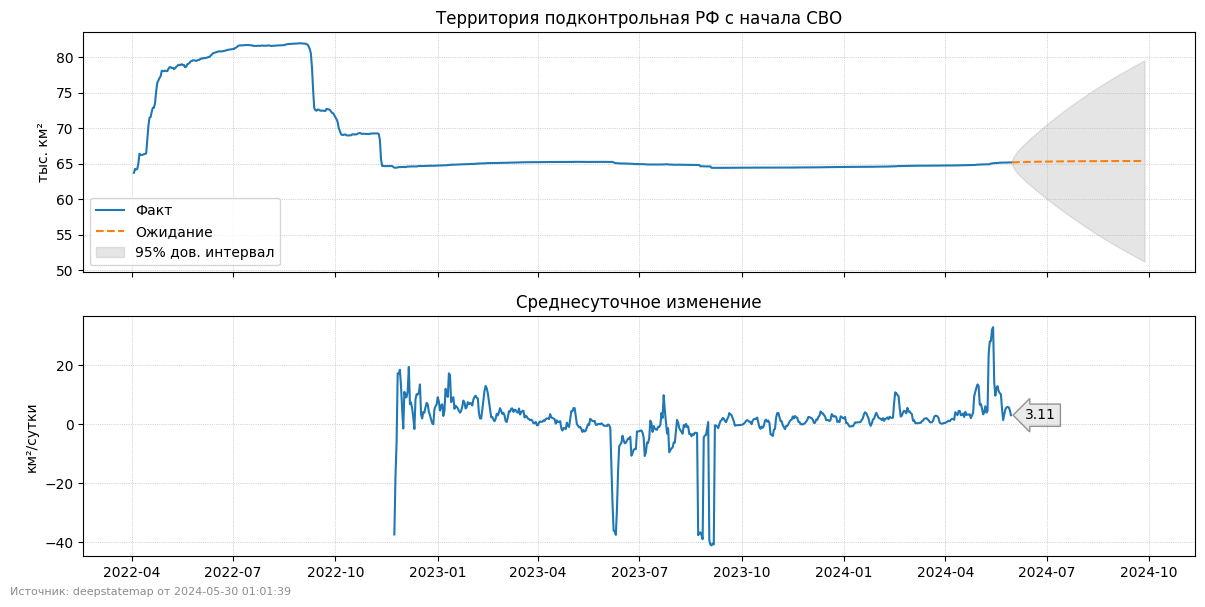

In [22]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)
ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True, min_periods=int(5 / 2)).mean()
)
sns.lineplot(
    day_din_area["area"],
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=12 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)